In [0]:
!pip install kaggle

In [0]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
# !rm -rf *

In [0]:
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 28.0MB/s]
 97% 529M/543M [00:09<00:00, 46.7MB/s]
100% 543M/543M [00:09<00:00, 57.3MB/s]
 98% 266M/271M [00:07<00:00, 62.1MB/s]
100% 271M/271M [00:07<00:00, 35.9MB/s]


In [0]:
!unzip -q train.zip

In [0]:
!mkdir -p data/train/cats
!mkdir -p data/train/dogs

!mkdir -p data/validation/cats
!mkdir -p data/validation/dogs
!mkdir -p data/test/cats
!mkdir -p data/test/dogs

!mkdir -p working/

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

from keras.applications.resnet_v2 import ResNet50V2
# from keras.applications.resnet import ResNet50
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import optimizers

# from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet_v2 import ResNet50V2
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping, ModelCheckpoint


Using TensorFlow backend.


In [0]:
dataset = np.random.permutation(os.listdir("train"))
filenames = dataset[0:3000]
test_set = dataset[3001:]
X_train = filenames[0:2000]
X_test = filenames[2001:]
for filename1 in X_train:
    category = filename1.split('.')[0]
    if category == 'dog':
        os.rename("train/"+filename1, "data/train/dogs/"+filename1)
    else:
        os.rename("train/"+filename1, "data/train/cats/"+filename1)

for filename2 in X_test:
    category = filename2.split('.')[0]
    if category == 'dog':
        os.rename("train/"+filename2, "data/validation/dogs/"+filename2)
    else:
        os.rename("train/"+filename2, "data/validation/cats/"+filename2)

for filename3 in test_set:
    category = filename3.split('.')[0]
    if category == 'dog':
        os.rename("train/"+filename3, "data/test/dogs/"+filename3)
    else:
        os.rename("train/"+filename3, "data/test/cats/"+filename3)

In [0]:
!ls -l data/train/dogs | wc -l

963


In [0]:
#CONSTANTS

NUM_CLASSES = 2
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 20
EARLY_STOP_PATIENCE = 3

STEPS_PER_EPOCH_TRAINING = 20
STEPS_PER_EPOCH_VALIDATION = 10

BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

BATCH_SIZE_TESTING = 1

In [0]:
model = Sequential()
model.add(ResNet50V2(include_top=False, weights='imagenet', pooling = RESNET50_POOLING_AVERAGE))
model.add(Dense(8192))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))
model.layers[0].trainable = False


In [0]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_9 (Dense)              (None, 8192)              16785408  
_________________________________________________________________
dropout_4 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 4096)              33558528  
_________________________________________________________________
dropout_5 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 8194      
Total params: 73,916,930
Trainable params: 50,352,130
Non-trainable params: 23,564,800
_________________________________

In [0]:
sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [0]:
image_size = IMAGE_RESIZE

train_datagen = ImageDataGenerator(
        # preprocessing_function=preprocess_input,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING)

validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        # target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    # target_size=(image_size, image_size),
    batch_size=BATCH_SIZE_TRAINING)

Found 2000 images belonging to 2 classes.
Found 999 images belonging to 2 classes.
Found 21999 images belonging to 2 classes.


Labels: [array([0., 1.], dtype=float32), array([1., 0.], dtype=float32), array([0., 1.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32)]


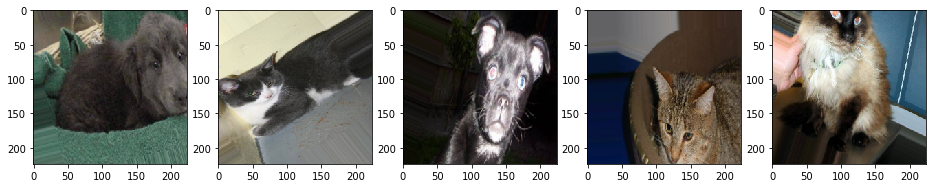

In [0]:
img_id = 500
cat = [next(train_generator) for i in range(0,5)] 
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat]) 
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

In [0]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', 
                                 patience = EARLY_STOP_PATIENCE)

cb_checkpointer = ModelCheckpoint(filepath = '/content/working/bestV2.hdf5', 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'auto')

In [0]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights('/content/working/bestV2.hdf5')

Epoch 1/20
10/10 [==============================] - 34s 3s/step - loss: 0.9681 - acc: 0.7720 - val_loss: 0.1180 - val_acc: 0.9800
Epoch 2/20
10/10 [==============================] - 15s 1s/step - loss: 0.3325 - acc: 0.9080 - val_loss: 0.1114 - val_acc: 0.9740
Epoch 3/20
10/10 [==============================] - 21s 2s/step - loss: 0.2183 - acc: 0.9400 - val_loss: 0.0636 - val_acc: 0.9860
Epoch 4/20
10/10 [==============================] - 21s 2s/step - loss: 0.2653 - acc: 0.9180 - val_loss: 0.1411 - val_acc: 0.9630
Epoch 5/20
10/10 [==============================] - 21s 2s/step - loss: 0.3226 - acc: 0.9130 - val_loss: 0.0543 - val_acc: 0.9900
Epoch 6/20
10/10 [==============================] - 21s 2s/step - loss: 0.2620 - acc: 0.9180 - val_loss: 0.1307 - val_acc: 0.9710
Epoch 7/20
10/10 [==============================] - 21s 2s/step - loss: 0.2306 - acc: 0.9250 - val_loss: 0.0707 - val_acc: 0.9840
Epoch 8/20
10/10 [==============================] - 21s 2s/step - loss: 0.2210 - acc: 0.92

In [0]:
model.evaluate_generator(test_generator)

[0.06966076669343003, 0.9862266573625682]